In [0]:
import os
import sys
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [0]:
## Folder Locations
TEST_IMAGE_FOLDER = '/content/Ballot/Test/testset'
TEST_CSV = '/content/Ballot/Test/testset.csv'

TRAIN_IMAGE_FOLDER = '/content/Ballot paper/Train/testset'
TRAIN_CSV = '/content/Ballot paper/Train/testset.csv'



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_set = pd.read_csv(TRAIN_CSV)
test_set = pd.read_csv(TEST_CSV)
train_set.head()

,Data,Label
0,600795.jpeg,10
1,627152.jpeg,10
2,119963.jpeg,10
3,118264.jpeg,10
4,199420.jpeg,10


In [0]:
test_set.head()

,Data,Label
0,632755.jpeg,10
1,496855.jpeg,10
2,155390.jpeg,10
3,265013.jpeg,10
4,496360.jpeg,10


In [0]:
test_set['Label'] = test_set['Label'].apply(str)
train_set['Label'] = train_set['Label'].apply(str)

# Image Data generator

In [0]:
from keras_preprocessing.image import ImageDataGenerator

In [0]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [0]:
TARGET_SIZE=(224, 224)


train_generator=datagen.flow_from_dataframe(
dataframe=train_set,
directory=TRAIN_IMAGE_FOLDER,
x_col="Data",
y_col="Label",
subset="training",
batch_size=32,
seed=RANDOM_STATE,
shuffle=True,
class_mode="categorical",
target_size=TARGET_SIZE)


valid_generator=datagen.flow_from_dataframe(
dataframe=train_set,
directory=TRAIN_IMAGE_FOLDER,
x_col="Data",
y_col="Label",
subset="validation",
batch_size=24,
seed=RANDOM_STATE,
shuffle=True,
class_mode="categorical",
target_size=TARGET_SIZE)


test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_set,
directory=TEST_IMAGE_FOLDER,
x_col="Data",
y_col=None,
batch_size=32,
seed=RANDOM_STATE,
shuffle=False,
class_mode=None,
target_size=TARGET_SIZE)




Found 7200 validated image filenames belonging to 48 classes.
Found 2400 validated image filenames belonging to 48 classes.
Found 2609 validated image filenames.


## MobileNet

In [0]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from tensorflow.keras.optimizers import Adam

In [0]:
base_model = keras.applications.mobilenet.MobileNet(weights='imagenet',include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(48,activation='softmax')(x) #final layer with softmax activation

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:

for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                
                   epochs=5,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/5
225/225 [==============================] - 43s 190ms/step - loss: 0.0162 - accuracy: 0.9972 - val_loss: 48.6570 - val_accuracy: 0.0000e+00
Epoch 2/5
225/225 [==============================] - 42s 187ms/step - loss: 0.0565 - accuracy: 0.9928 - val_loss: 48.5133 - val_accuracy: 0.0000e+00
Epoch 3/5
225/225 [==============================] - 42s 186ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 51.4554 - val_accuracy: 0.0000e+00
Epoch 4/5
225/225 [==============================] - 42s 185ms/step - loss: 4.7588e-05 - accuracy: 1.0000 - val_loss: 53.1590 - val_accuracy: 0.0000e+00
Epoch 5/5
225/225 [==============================] - 42s 186ms/step - loss: 1.8171e-05 - accuracy: 1.0000 - val_loss: 54.6672 - val_accuracy: 0.0000e+00


In [0]:
predictions.shape

(2609, 48)

In [0]:
import tensorflow
prediction_indices = tensorflow.math.argmax(predictions, 1)
prediction_indices

<tf.Tensor: shape=(2609,), dtype=int64, numpy=array([ 3,  3,  3, ..., 34, 34, 34])>

In [0]:
predicted_values = []

for i in prediction_indices:
    predicted_values.append(label_map_swapped[i.numpy()])

In [0]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(predicted_values, test_set['Label'])


In [0]:
acc

0.7566117286316596

In [0]:

from sklearn.metrics import classification_report
print(classification_report(predicted_values, test_set['Label']))

              precision    recall  f1-score   support

           0       0.97      0.18      0.31       159
           1       1.00      1.00      1.00        33
          10       0.00      0.00      0.00         0
          11       1.00      0.84      0.91       112
          12       1.00      1.00      1.00        88
          13       1.00      1.00      1.00        92
          14       1.00      1.00      1.00        14
          15       1.00      0.48      0.65       104
          16       0.00      0.00      0.00         0
          17       1.00      0.74      0.85        19
          18       1.00      1.00      1.00        65
          19       1.00      0.99      0.99        75
           2       1.00      0.89      0.94        18
          20       1.00      1.00      1.00        86
          21       1.00      1.00      1.00        22
          22       1.00      0.90      0.95        90
          23       0.00      0.00      0.00         0
          24       0.99    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
!pip install -q scikit-plot

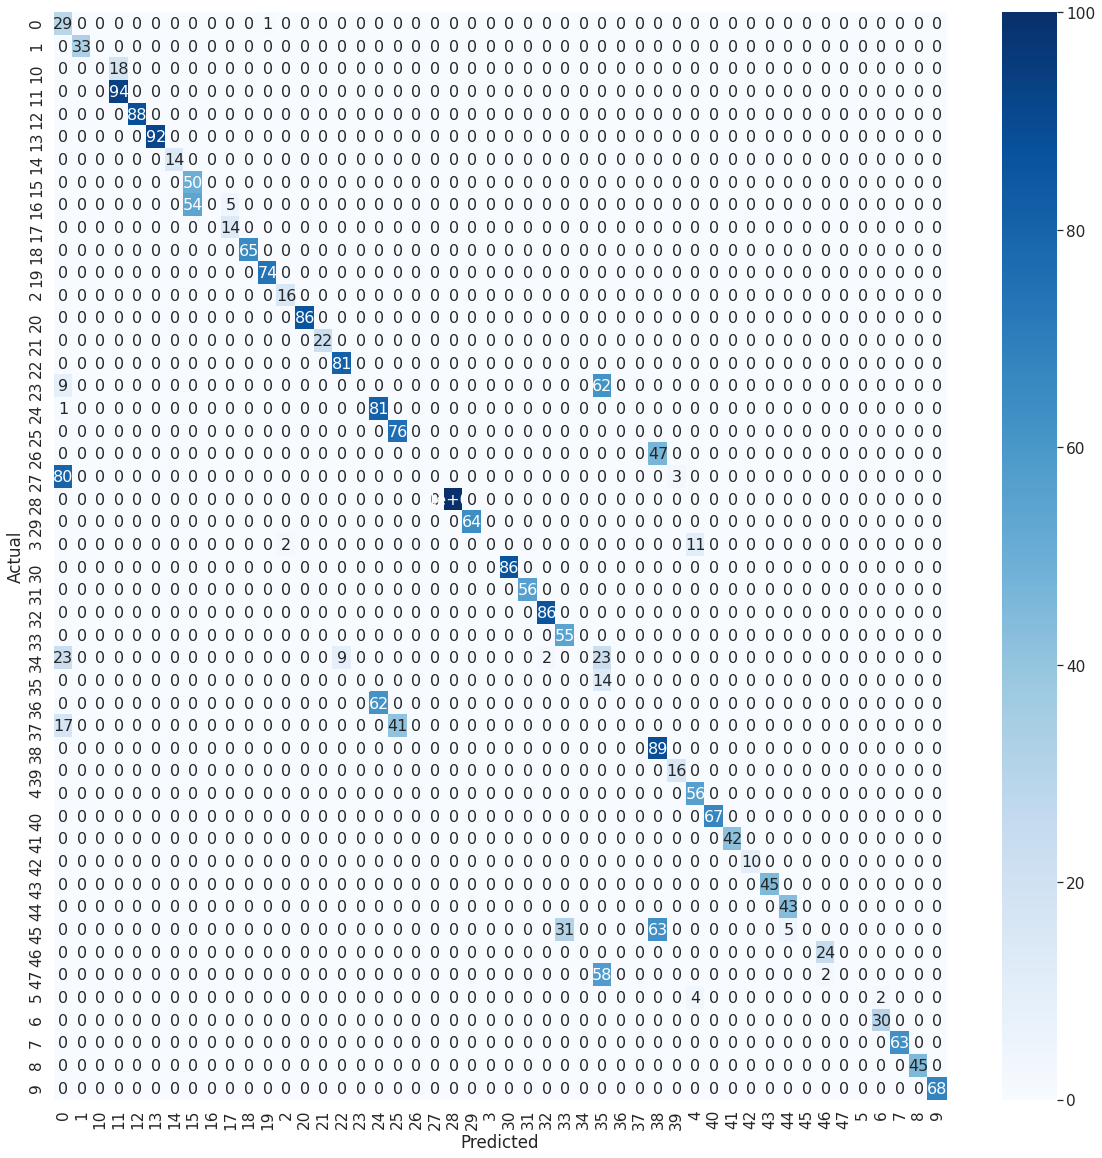

In [0]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

y_true = test_set['Label']
y_pred = predicted_values
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size